In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [3]:
N = 15
h = 1/(N+1)

nodes = np.linspace(0, 1, N+2)
nodes

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    ])

In [4]:
def phi(i, x, deriv=False):
    "Linear piecewise affine function finite element basis"
    try:
        if not isinstance(i, int):
            raise TypeError(f"Variable 'i' must be an integer, got {i}")
        if not (0 <= i <= N+1):
            raise ValueError(f"Variable 'i' must be an integer between 0 and N+1, got {i}")

        if deriv == False:
            if i == 0:
                if nodes[0] <= x <= nodes[1]:
                    return 1 - (x-nodes[i])/h
                else:
                    return 0
            if i == N+1:
                if nodes[-2] <= x <= nodes[-1]:
                    return 1 + (x-nodes[i])/h
                else:
                    return 0
            if 0 < i < N+1:
                if nodes[i-1] <= x <= nodes[i]:
                    return 1 + (x-nodes[i])/h
                elif nodes[i] < x <= nodes[i+1]:
                    return 1 - (x-nodes[i])/h
                else:
                    return 0

        if deriv:
            if i == 0:
                if nodes[0] <= x <= nodes[1]:
                    return -1/h
                else:
                    return 0
            if i == N+1:
                if nodes[-2] <= x <= nodes[-1]:
                    return 1/h
                else:
                    return 0
            if 0 < i < N+1:
                if nodes[i-1] <= x <= nodes[i]:
                    return 1/h
                elif nodes[i] < x <= nodes[i+1]:
                    return -1/h
                else:
                    return 0

    except Exception as err:
        print(f"Error: {err}")

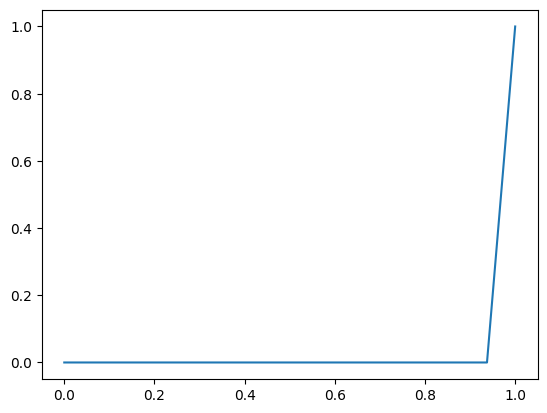

In [6]:
plt.plot(nodes, [phi(N+1, x) for x in nodes])

$- \frac{\partial}{\partial x} (a(x)\frac{\partial u}{\partial x}) + b(x) \frac{\partial u}{\partial x} + c(x)u = f(x)$

Functions $a(x), b(x), c(x), f(x)$ are extended real valued functions in a 1D space where $a(x), b(x), c(x) \in L^{\infty}$ and $f(x) \in L^2$

$ a(x)u'' + b(x) u' + c(x)u = f(x)$

In [5]:
def a(x):
    return -1

def b(x):
    return 0

def c(x):
    return 1

def f(x):
    return 1

# Dirichlet Boundary Conditions

Seek a solution $u_h + \hat{u}$ where $u_h \in H^1_0(0,1)$ and $\hat{u} \in H^1(0,1)$ satisfies the boundary conditions $\hat{u}(0) = u(0)$ and $\hat{u}(1) = u(1)$.

An easy way to fulfill this condition is by defining: </br>

$\hat{u}(x) = u(0) + (u(1)-u(0))x$

So the weak form of the PDE is to find $u_h \in H^1_0(0,1)$ satisfying

$$\int_0^1 -a(x) u_h'v' +  b(x) u_h' v + c(x) u_h v \ dx = \int_0^1 f(x)v \ dx - \int_0^1 -a(x) \hat{u}'v' +  b(x) \hat{u}' v + c(x) \hat{u} v \ dx \hspace{0.5cm} \forall v \in H^1_0(0,1)$$

In [83]:
u0 = 2
u1 = 6

In [84]:
def bilinear_form(u,i,v,j):
    return integrate.quad(lambda x: -a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + b(x)*u(i,x,deriv=True)*v(j,x) + c(x)*u(i,x)*v(j,x), 0, 1)[0]

# phi_0 and phi_N+1 are not part of the space
A = np.zeros((N, N))

for i in range(1,N+1):
    A[i-1,i-1] = bilinear_form(phi,i,phi,i)

for i in range(1,N):
    A[i-1,i] = bilinear_form(phi,i+1,phi,i)
    A[i,i-1] = bilinear_form(phi,i,phi,i+1)

In [85]:
def linear_functional(v,i):
    return integrate.quad(lambda x: f(x)*v(i,x), 0, 1)[0]

def u_hat(x,i,deriv=False):
    if deriv == False:
        return u0+(u1-u0)*x
    if deriv:
        return u1-u0

f_array = np.empty(N)

for i in range(1,N+1):
    f_array[i-1] = linear_functional(phi,i) - bilinear_form(u_hat,i,phi,i)

In [86]:
U = np.linalg.solve(A, f_array)
U

array([0.13343683, 0.24363507, 0.33200311, 0.399864  , 0.44846059,
       0.47896042, 0.49246026, 0.48999041, 0.47251873, 0.44095443,
       0.3961516 , 0.33891258, 0.26999108, 0.19009512, 0.09988982])

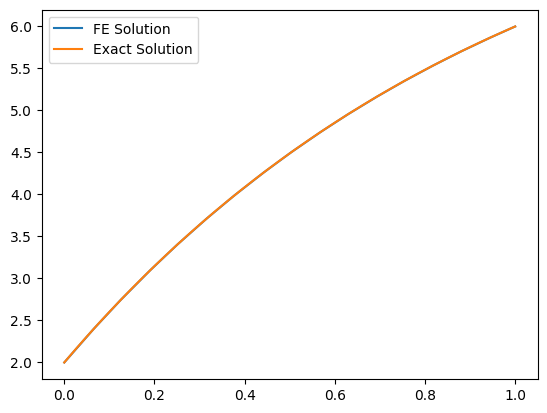

In [87]:
def u_h(x):
    approx = 0
    for i in range(N):
        approx += U[i]*phi(i+1,x)
    return approx

def u_exact(x):
    e = np.e
    return 2*((1-3*e)*e**x+2*e)*e**(-x)/(1-e)

xes = np.linspace(0,1,200)
plt.plot(xes, [u_h(x) + u_hat(x,i) for x in xes], label = "FE Solution")
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

# Neumann Boundary Conditions

In [15]:
du0 = 2
du1 = 0

In [16]:
def bilinear_form(u,i,v,j):
    return integrate.quad(lambda x: -a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + b(x)*u(i,x,deriv=True)*v(j,x) + c(x)*u(i,x)*v(j,x), 0, 1)[0]

# phi_0 to phi_N+1 are all part of the space
A = np.zeros((N+2, N+2))

for i in range(N+2):
    A[i,i] = bilinear_form(phi,i,phi,i)

for i in range(N+1):
    A[i,i+1] = bilinear_form(phi,i+1,phi,i)
    A[i+1,i] = bilinear_form(phi,i,phi,i+1)

In [17]:
def linear_functional(v,i):
    return integrate.quad(lambda x: f(x)*v(i,x), 0, 1)[0]

f_array = np.empty(N+2)
for i in range(N+2):
    f_array[i] = linear_functional(phi,i)
f_array[0] += a(0)*du0*phi(0,0)
f_array[N] += -a(1)*du1*phi(N+1,1)

f_array

array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
U = np.linalg.solve(A, f_array)
U

array([1.28485395, 1.40726477, 1.52418204, 1.63514936, 1.73973352,
       1.83752627, 1.92814586, 2.01123852, 2.0864799 , 2.15357627,
       2.2122657 , 2.26231909, 2.30354105, 2.33577066, 2.3588821 ,
       2.37278515, 2.37742553])

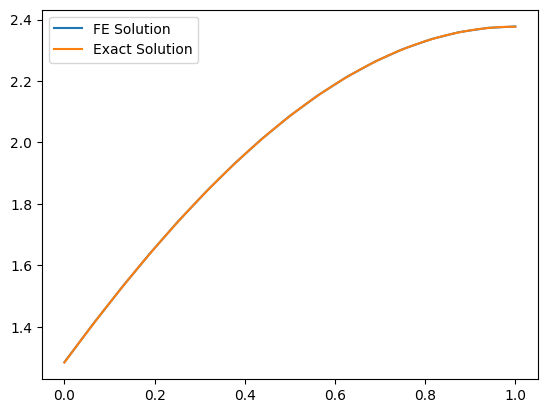

In [21]:
def u_h(x):
    approx = 0
    for i in range(N+2):
        approx += U[i]*phi(i,x)
    return approx

def u_exact(x):
    return 2*np.cos(x-1)/np.sin(1)

xes = np.linspace(0,1,200)
plt.plot(xes, [u_h(x) for x in xes], label = "FE Solution")
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

# Mixed Dirichlet and Neumann - $u(0)$ and $u'(1)$

In [20]:
u0 = 0
du1 = 0

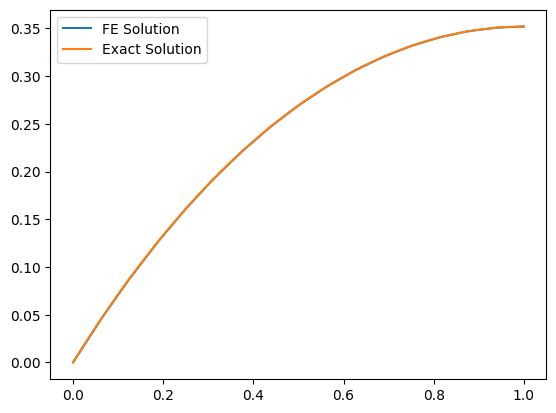

In [21]:
def bilinear_form(u,i,v,j):
    return integrate.quad(lambda x: -a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + b(x)*u(i,x,deriv=True)*v(j,x) + c(x)*u(i,x)*v(j,x), 0, 1)[0]

def linear_functional(v,i):
    return integrate.quad(lambda x: (f(x)-c(x)*u0)*v(i,x), 0, 1)[0]

# phi_0 is not part of the space
A = np.zeros((N+1, N+1))

for i in range(1,N+2):
    A[i-1,i-1] = bilinear_form(phi,i,phi,i)

for i in range(1,N+1):
    A[i-1,i] = bilinear_form(phi,i+1,phi,i)
    A[i,i-1] = bilinear_form(phi,i,phi,i+1)

# phi_N+1 provides boundary condition at u1
f_array = np.empty(N+1)
for i in range(1,N+2):
    f_array[i-1] = linear_functional(phi,i)
f_array[N] += -a(1)*du1*phi(N+1,1)

U = np.linalg.solve(A, f_array)

def u_h(x):
    approx = 0
    for i in range(N+1):
        approx += U[i]*phi(i+1,x)
    return approx

def u(x):
    return 1 - (np.e**(2-x) + np.e**x)/(1 + np.e**2)

xes = np.linspace(0,1,200)
plt.plot(xes, [u_h(x) + u0 for x in xes], label = "FE Solution")
plt.plot(xes, [u(x) for x in xes], label = "Exact Solution")
plt.legend()


# Mixed Dirichlet and Neumann - $u'(0)$ and $u(1)$

In [22]:
du0 = 2
u1 = 5

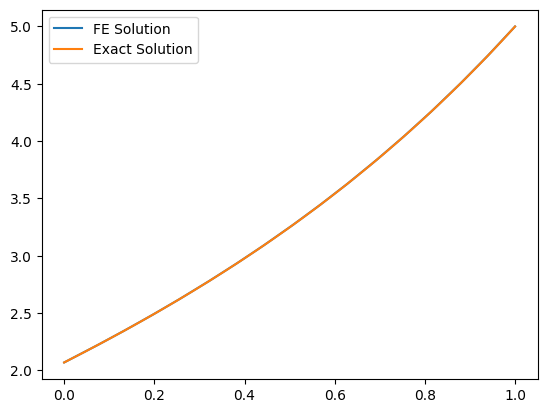

In [24]:
def bilinear_form(u,i,v,j):
    return integrate.quad(lambda x: -a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + b(x)*u(i,x,deriv=True)*v(j,x) + c(x)*u(i,x)*v(j,x), 0, 1)[0]

def linear_functional(v,i):
    return integrate.quad(lambda x: (f(x)-c(x)*u1)*v(i,x), 0, 1)[0]

# phi_N+1 is not part of the space
A = np.zeros((N+1, N+1))

for i in range(N+1):
    A[i,i] = bilinear_form(phi,i,phi,i)

for i in range(N):
    A[i,i+1] = bilinear_form(phi,i+1,phi,i)
    A[i+1,i] = bilinear_form(phi,i,phi,i+1)

# phi_0 provides boundary condition at u0
f_array = np.empty(N+1)
for i in range(N+1):
    f_array[i] = linear_functional(phi,i)
f_array[0] += a(0)*du0*phi(0,0)

U = np.linalg.solve(A, f_array)

def u_h(x):
    approx = 0
    for i in range(N+1):
        approx += U[i]*phi(i,x)
    return approx

def u(x):
    return 2*(1+2*np.e)*np.e**x/(1+np.e**2)+(2-np.e)*np.e**(-x)/(np.cosh(1)) + 1

xes = np.linspace(0,1,200)
plt.plot(xes, [u_h(x) + u1 for x in xes], label = "FE Solution")
plt.plot(xes, [u(x) for x in xes], label = "Exact Solution")
plt.legend()

# Robin Boundary Conditions

The conditions are of the following general form ($\beta > 0$)

$ u'(0) - \beta u(0) = g_0 $ </br>
$ u'(1) + \beta u(1) = g_1 $

The weak formulation is to find $u \in H^1(0,1)$ satisfying

$$\int_0^1 -a(x) u'v' +  b(x) u' v + c(x) u v \ dx - \beta \ a(x) u(0)v(0)
- \beta \ a(x) u(1)v(1)
= \int_0^1 fv \ dx + g_0 a(x) v(0) - g_1 a(x) v(1) \hspace{0.5cm} \forall v \in H^1(0,1)$$